In [1]:
pip install imgaug

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\asdan\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

import random


# Load Dataset

(6000, 90, 90, 1)
[[[255]
  [255]
  [255]
  ...
  [255]
  [255]
  [255]]

 [[255]
  [255]
  [255]
  ...
  [255]
  [255]
  [255]]

 [[255]
  [255]
  [255]
  ...
  [255]
  [255]
  [255]]

 ...

 [[255]
  [255]
  [255]
  ...
  [255]
  [255]
  [255]]

 [[255]
  [255]
  [255]
  ...
  [255]
  [255]
  [255]]

 [[255]
  [255]
  [255]
  ...
  [255]
  [255]
  [255]]]


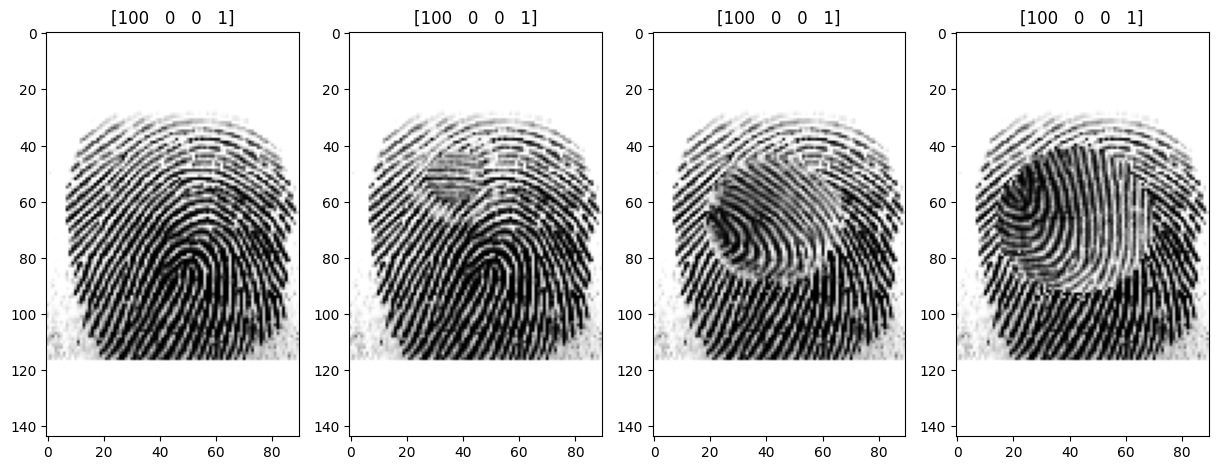

In [3]:
x_real = np.load('dataset/x_real.npz')['data']
y_real = np.load('dataset/y_real.npy')
x_easy = np.load('dataset/x_easy.npz')['data']
y_easy = np.load('dataset/y_easy.npy')
x_medium = np.load('dataset/x_medium.npz')['data']
y_medium = np.load('dataset/y_medium.npy')
x_hard = np.load('dataset/x_hard.npz')['data']
y_hard = np.load('dataset/y_hard.npy')

print(x_real.shape)

x_real = np.pad(x_real, ((0, 0), (27, 27), (0, 0), (0, 0)), mode='constant',constant_values=255)
x_easy= np.pad(x_easy, ((0, 0), (27,27), (0, 0), (0, 0)), mode='constant',constant_values=255)
x_medium = np.pad(x_medium, ((0, 0),(27,27), (0, 0), (0, 0)), mode='constant',constant_values=255)
x_hard = np.pad(x_hard, ((0, 0), (27,27), (0, 0), (0, 0)), mode='constant',constant_values=255)


# print("x_real shape:", x_real.shape, " size:", x_real.size)
# print("x_easy shape:", x_easy.shape, " size:", x_easy.size)
# print("x_medium shape:", x_medium.shape, " size:", x_medium.size)
# print("x_hard shape:", x_hard.shape, " size:", x_hard.size)
# print(x_real.shape, y_real.shape)

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title(y_real[0])
plt.imshow(x_real[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 2)
plt.title(y_easy[0])
plt.imshow(x_easy[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 3)
plt.title(y_medium[0])
plt.imshow(x_medium[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 4)
plt.title(y_hard[0])
plt.imshow(x_hard[0].squeeze(), cmap='gray')
print(x_real[0])

# Train Test Split

In [4]:
x_data = np.concatenate([x_easy, x_medium, x_hard], axis=0)
label_data = np.concatenate([y_easy, y_medium, y_hard], axis=0)

x_train, x_val, label_train, label_val = train_test_split(x_data, label_data, test_size=0.1)
print(x_data.shape, label_data.shape)
print(x_train.shape, label_train.shape)
print(x_val.shape, label_val.shape)

(49270, 144, 90, 1) (49270, 4)
(44343, 144, 90, 1) (44343, 4)
(4927, 144, 90, 1) (4927, 4)


# Preview Augmentation

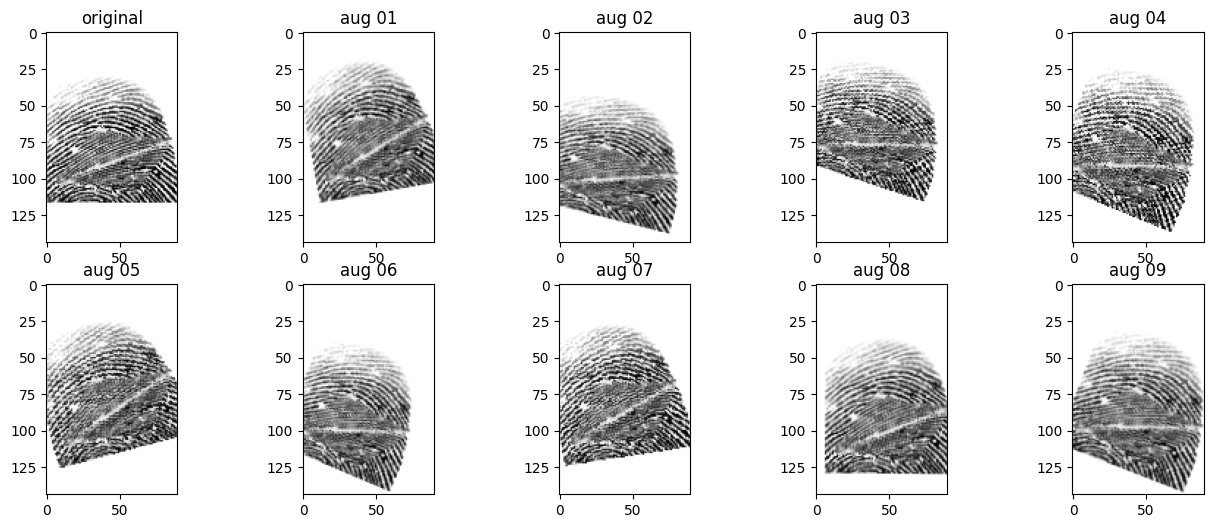

In [5]:
augs = [x_data[40000]] * 9

seq = iaa.Sequential([
    # blur images with a sigma of 0 to 0.5
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        # scale images to 90-110% of their size, individually per axis
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        # translate by -10 to +10 percent (per axis)
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        # rotate by -30 to +30 degrees
        rotate=(-30, 30),
        # use nearest neighbour or bilinear interpolation (fast)
        order=[0, 1],
        # if mode is constant, use a cval between 0 and 255
        cval=255
    )
], random_order=True)

augs = seq.augment_images(augs)

plt.figure(figsize=(16, 6))
plt.subplot(2, 5, 1)
plt.title('original')
plt.imshow(x_data[40000].squeeze(), cmap='gray')
for i, aug in enumerate(augs):
    plt.subplot(2, 5, i+2)
    plt.title('aug %02d' % int(i+1))
    plt.imshow(aug.squeeze(), cmap='gray')

# Make Label Dictionary Lookup Table

In [6]:
label_real_dict = {}

for i, y in enumerate(y_real):
    key = y.astype(str)
    key = ''.join(key).zfill(6)

    label_real_dict[key] = i

# Data Generator

In [8]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True):
        'Initialization'
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x1_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]
        
        x2_batch = np.empty((self.batch_size, 144,90, 1), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)
        
        # augmentation
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                    rotate=(-30, 30),
                    order=[0, 1],
                    cval=255
                )
            ], random_order=True)

            x1_batch = seq.augment_images(x1_batch)
        
        # pick matched images(label 1.0) and unmatched images(label 0.0) and put together in batch
        # matched images must be all same, [subject_id(3), gender(1), left_right(1), finger(1)], e.g) 034010
        for i, l in enumerate(label_batch):
            match_key = l.astype(str)
            match_key = ''.join(match_key).zfill(6)

            if random.random() > 0.5:
                # put matched image
                x2_batch[i] = self.x_real[self.label_real_dict[match_key]]
                y_batch[i] = 1.
            else:
                # put unmatched image
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))

                    if unmatch_key != match_key:
                        break

                x2_batch[i] = self.x_real[unmatch_idx]
                y_batch[i] = 0.

        return [x1_batch.astype(np.float32) / 255., x2_batch.astype(np.float32) / 255.], y_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)

In [9]:
train_gen = DataGenerator(x_train, label_train, x_real, label_real_dict, shuffle=True)
val_gen = DataGenerator(x_val, label_val, x_real, label_real_dict, shuffle=False)

([array([[[[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        ...,

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]]],


       [[[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        ...,

        [[1.],

In [13]:
with open('output.txt', 'w') as f:
    # Iterate through each pixel and write its value to the file
    for row in train_gen[0]:
        for pixel in row:
            if pixel.any()>0 and pixel.any()<1:
                f.write(str(pixel) + '\n')
                


# Create Model

In [10]:
x1 = layers.Input(shape=(144,90, 1))
x2 = layers.Input(shape=(144,90, 1))

# share weights both inputs
inputs = layers.Input(shape=(144,90,1))

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature_model = Model(inputs=inputs, outputs=feature)

# 2 feature models that sharing weights
x1_net = feature_model(x1)
x2_net = feature_model(x2)

# subtract features
net = layers.Subtract()([x1_net, x2_net])

net = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(net)
net = layers.MaxPooling2D(pool_size=2)(net)

net = layers.Flatten()(net)

net = layers.Dense(64, activation='relu')(net)

net = layers.Dense(1, activation='sigmoid')(net)

model = Model(inputs=[x1, x2], outputs=net)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()




Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 144, 90, 1)]         0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 144, 90, 1)]         0         []                            
                                                                                                  
 model (Functional)          (None, 36, 22, 32)           9568      ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 subtract (Subtract)         (None, 36, 22, 32)           0         ['model[0][0]',      

# Train

In [61]:
history = model.fit_generator(train_gen, epochs=15, validation_data=val_gen)

C:\Users\asdan\AppData\Local\Temp\ipykernel_13640\3063625660.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, epochs=15, validation_data=val_gen)


Epoch 1/15


1385/1385 [==============================] - 215s 154ms/step - loss: 0.2552 - acc: 0.8887 - val_loss: 0.0910 - val_acc: 0.9673
Epoch 2/15
1385/1385 [==============================] - 209s 151ms/step - loss: 0.1564 - acc: 0.9390 - val_loss: 0.0342 - val_acc: 0.9890
Epoch 3/15
1385/1385 [==============================] - 217s 157ms/step - loss: 0.1169 - acc: 0.9556 - val_loss: 0.0399 - val_acc: 0.9861
Epoch 4/15
1385/1385 [==============================] - 225s 162ms/step - loss: 0.1003 - acc: 0.9634 - val_loss: 0.0281 - val_acc: 0.9894
Epoch 5/15
1385/1385 [==============================] - 221s 160ms/step - loss: 0.0840 - acc: 0.9696 - val_loss: 0.0248 - val_acc: 0.9924
Epoch 6/15
1385/1385 [==============================] - 232s 167ms/step - loss: 0.0778 - acc: 0.9725 - val_loss: 0.0245 - val_acc: 0.9908
Epoch 7/15
1385/1385 [==============================] - 233s 168ms/step - loss: 0.0724 - acc: 0.9734 - val_loss: 0.0197 - val_acc: 0.9939
Epoch 8/15
1385/1385 [==========

In [11]:
from tensorflow.keras.models import model_from_json
def save_model(model, filepath):
    # Save the model weights and architecture
    model.save_weights(filepath + '_weights.h5')
    with open(filepath + '_architecture.json', 'w') as f:
        f.write(model.to_json())

        
def load_model(filepath):
    # Load the model architecture
    with open(filepath + '_architecture.json', 'r') as f:
        loaded_model = model_from_json(f.read())
    # Load the model weights
    loaded_model.load_weights(filepath + '_weights.h5')
    return loaded_model

In [178]:
save_model(model, 'good_model')

 

In [12]:
from tensorflow.keras.models import model_from_json
mp = load_model('good_model')

In [13]:
test_datax = np.concatenate([x_easy,x_medium], axis=0)
test_datay = np.concatenate([y_easy,y_medium], axis=0)

# Evaluation

1836
615 1836
1/1 [==============================] - 0s 32ms/step


C:\Users\asdan\AppData\Local\Temp\ipykernel_8544\201431331.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('O: %.07f, %s' % (pred_rx, ry))


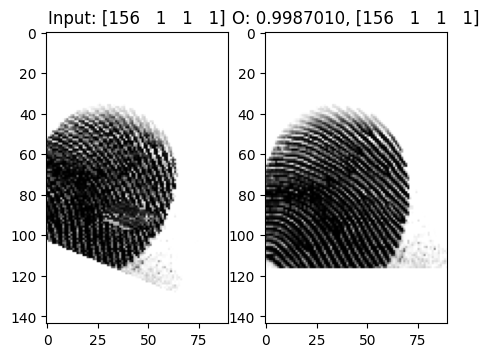

In [53]:
import random as random
from collections import defaultdict
# new user fingerprint input
random_idx = random.randint(0, len(test_datax))
# random_idx=2995
random_img = test_datax[random_idx]
random_label = test_datay[random_idx]

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=255
    )
], random_order=True)

random_img = seq.augment_image(random_img).reshape((1, 144, 90, 1)).astype(np.float32) / 255.
# plt.figure(figsize=(8, 4))
# plt.subplot(1, 3, 1)
# plt.title('Input: %s' %random_label)
# plt.imshow(random_img.squeeze(), cmap='gray')

ans=100.0
ansx=None
ansy=None
l=0
r=len(x_real)
print(random_idx)
# while l<r:
#     rx = x_real[l].reshape((1, 144, 90, 1)).astype(np.float32) / 255.
#     ry = y_real[l]
#     pred_rx=model.predict([random_img,rx])
#     print(l)
#     if pred_rx>ans:
#         ans=pred_rx
#         ansx=rx
#         ansy=ry
#     l+=1


# plt.figure(figsize=(8, 4))
# plt.subplot(1, 3, 1)
# plt.title('Input: %s' %random_label)
# plt.imshow(random_img.squeeze(), cmap='gray')
# plt.subplot(1, 3, 2)
# plt.title('O: %.02f, %s' % (ans, ansy))
# plt.imshow(ansx.squeeze(), cmap='gray')

# matched image
match_key = random_label.astype(str)
match_key = ''.join(match_key).zfill(6)
print (label_real_dict[match_key],random_idx)
rx = x_real[label_real_dict[match_key]].reshape((1, 144, 90, 1)).astype(np.float32) / 255.
ry = y_real[label_real_dict[match_key]]

pred_rx = mp.predict([random_img, rx])

# # unmatched image
# unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))

# ux = x_real[unmatch_idx].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
# uy = y_real[unmatch_idx]

# # pred_ux = mp.predict([random_img, ux])

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title('Input: %s' %random_label)
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('O: %.07f, %s' % (pred_rx, ry))
plt.imshow(rx.squeeze(), cmap='gray')

# plt.subplot(1, 3, 3)
# plt.title('X: %.02f, %s' % (pred_ux, uy))
# plt.imshow(ux.squeeze(), cmap='gray')

In [98]:
# import os
# import cv2 as cv2
# seq = iaa.Sequential([
#     iaa.GaussianBlur(sigma=(0, 0.5)),
#     iaa.Affine(
#         scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
#         translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
#         rotate=(-30, 30),
#         order=[0, 1],
#         cval=255
#     )
# ], random_order=True)
# img = cv.imread("file" , 0)
# img = seq.augment_image(img).reshape((1, 90, 90, 1)).astype(np.float32) / 255.
# for i in range(len(data)):
#     x=cv.imread(data[i] , 0 )
#     x.reshape((1, 90, 90, 1)).astype(np.float32) / 255.
#     model.predict([img,x])

# flask : image 
# img = cv2.imread(os.path.join("file/",1__M_Left_index_finger_CR.BMP))
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


1.0 0.1201429
1/1 [==============================] - 0s 35ms/step
[[0.9996654]]
1/1 [==============================] - 0s 33ms/step
[[0.9981191]]
1/1 [==============================] - ETA: 0s

C:\Users\asdan\AppData\Local\Temp\ipykernel_8544\4129775531.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('O: %.07f' % (pred_rxx))


1/1 [==============================] - 0s 31ms/step
[[0.99903584]]
1/1 [==============================] - 0s 30ms/step
[[0.00829169]]
1/1 [==============================] - 0s 34ms/step
[[2.4930983e-08]]
1/1 [==============================] - 0s 32ms/step
[[0.9888884]]
1/1 [==============================] - 0s 31ms/step
[[0.9971041]]
1/1 [==============================] - 0s 34ms/step
[[0.9990999]]
1/1 [==============================] - 0s 32ms/step
[[4.3147014e-12]]
1/1 [==============================] - 0s 31ms/step
[[0.01804155]]
1/1 [==============================] - 0s 31ms/step
[[3.0254374e-15]]
1/1 [==============================] - 0s 30ms/step
[[1.9535048e-05]]


C:\Users\asdan\AppData\Local\Temp\ipykernel_8544\4129775531.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('O: %.07f, %s' % (ans1, val))


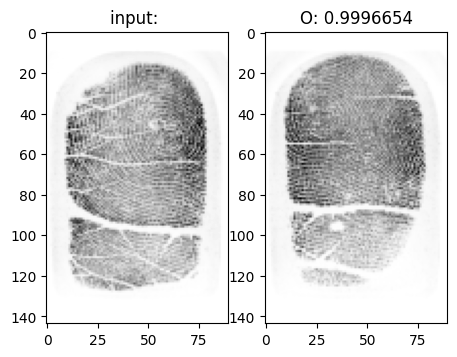

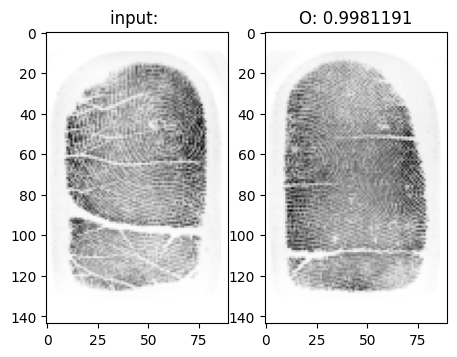

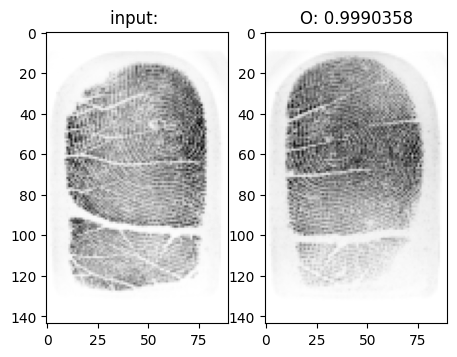

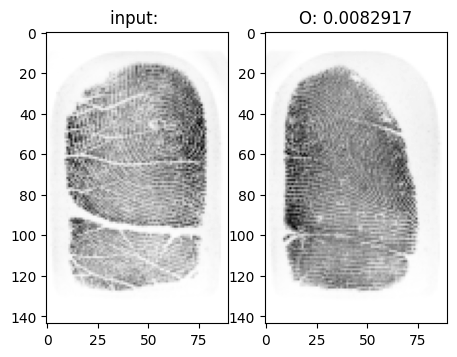

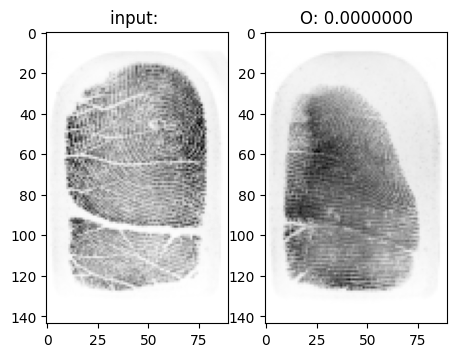

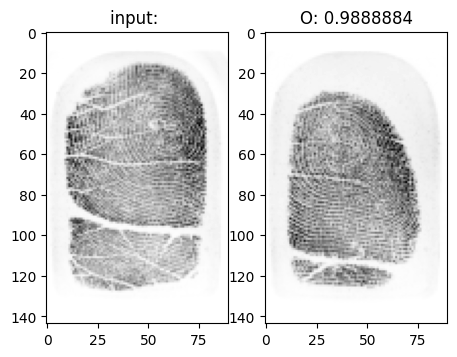

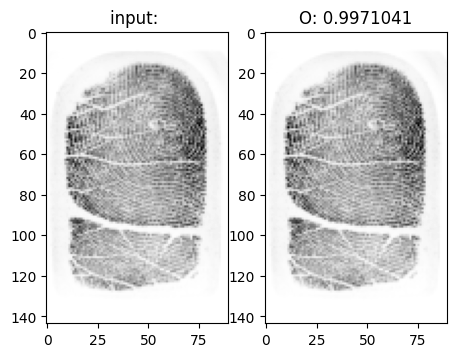

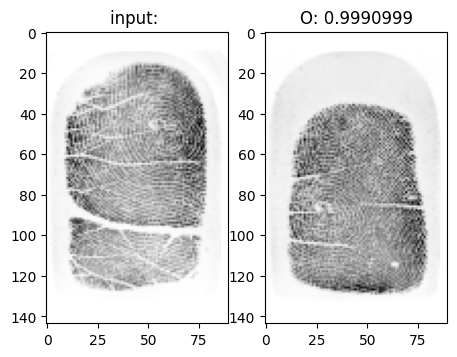

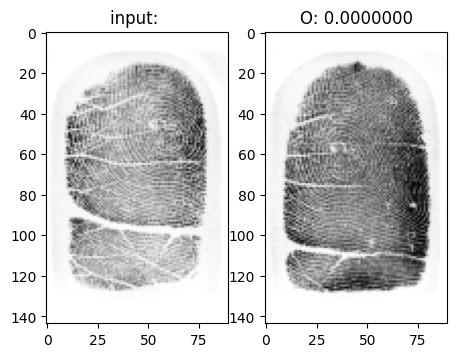

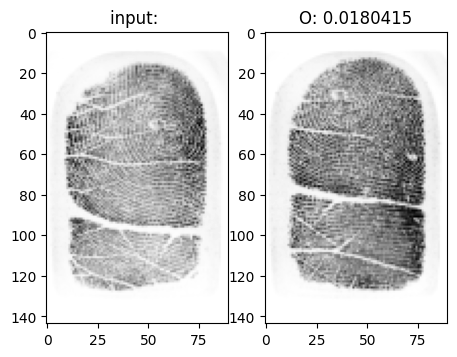

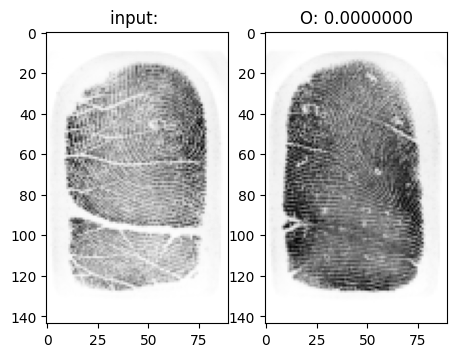

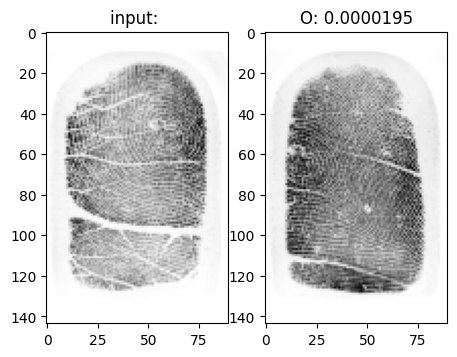

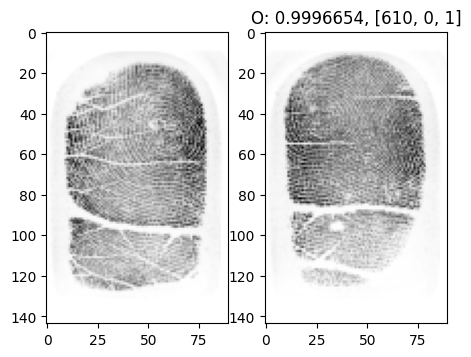

In [34]:
X = np.load('foot1.npz')
# Y=np.load('target2.npy')
random_idx1 = random.randint(0, len(X)-1)
# random_idx=2995
random_img1 = X[random_idx1]
# random_label1=Y[random_idx1]
seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=255
    )
], random_order=True)
val=[610,0,1]
print(random_img1.max(),random_img1.min())
random_img1 = random_img1.reshape((1, 144, 90, 1)).astype(np.float32) #/ 255.
ans1=0.0

ansxx=None
ansyy=None
l=0
r=len(X)
while l<r:
    rxx = X[l].reshape((1, 144, 90, 1)).astype(np.float32) #/ 255.
    # ryy=Y[l]
    pred_rxx=mp.predict([random_img1,rxx])
    print(pred_rxx)
    if pred_rxx>ans1:
        ans1=pred_rxx
        ansxx=X[l]
        # ansyy=Y[l]
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 3, 1)
    # plt.title('input: %s' %  random_label1)
    plt.title('input: ')
    plt.imshow(random_img1.squeeze(), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title('O: %.07f' % (pred_rxx))
    plt.imshow(rxx.squeeze(), cmap='gray')
    
    l+=1
plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
# plt.title('input: %s' %  random_label1)
plt.imshow(random_img1.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
# plt.title('O: %.02f, %s' % (ans1, ryy))
plt.title('O: %.07f, %s' % (ans1, val))
plt.imshow(ansxx.squeeze(), cmap='gray')
# print(ansxx)
# print(x_real[0])


1/1 [==============================] - 0s 28ms/step
[[0.54524016]]
1/1 [==============================] - 0s 28ms/step
[[5.30588e-15]]
1/1 [==============================] - 0s 30ms/step


C:\Users\asdan\AppData\Local\Temp\ipykernel_8544\2443190194.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('O: %.07f, %s' % (pred_rxx, ryy))


[[5.292792e-06]]
1/1 [==============================] - 0s 34ms/step
[[2.2269287e-06]]
1/1 [==============================] - 0s 28ms/step
[[1.6797449e-31]]
1/1 [==============================] - 0s 29ms/step
[[1.2998064e-10]]
1/1 [==============================] - 0s 29ms/step
[[2.4208766e-09]]
1/1 [==============================] - 0s 29ms/step
[[0.02669739]]
1/1 [==============================] - 0s 30ms/step
[[0.06715534]]
1/1 [==============================] - 0s 32ms/step
[[0.9971041]]


C:\Users\asdan\AppData\Local\Temp\ipykernel_8544\2443190194.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('O: %.07f, %s' % (ans1, ansyy))


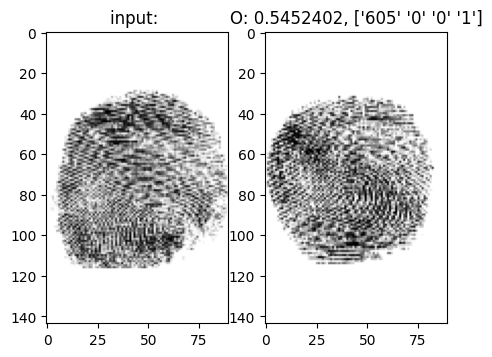

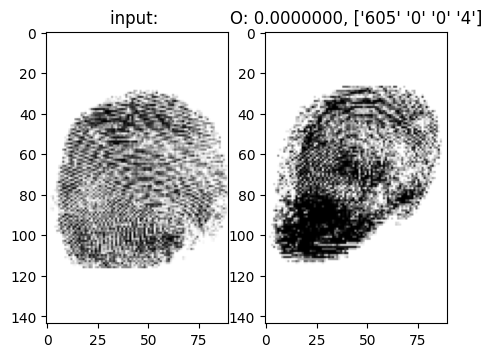

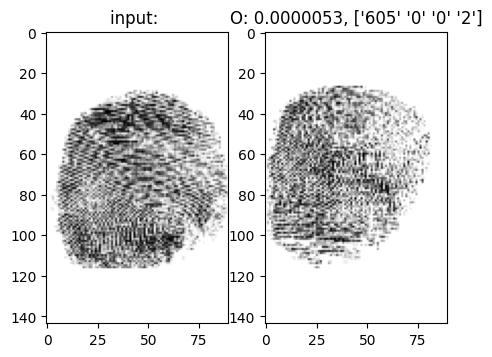

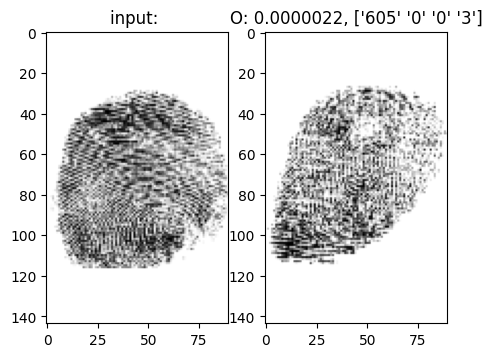

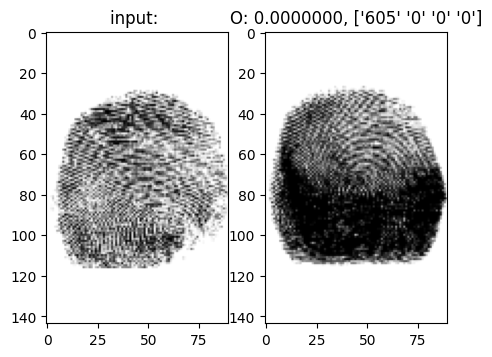

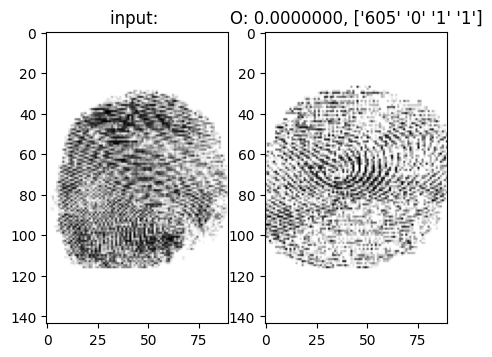

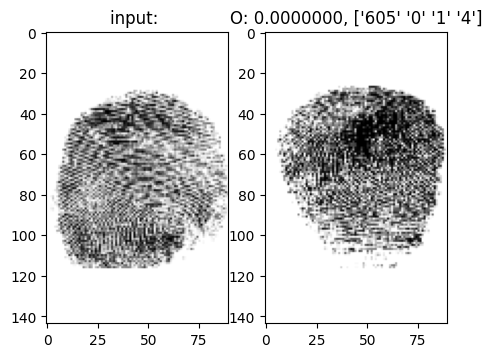

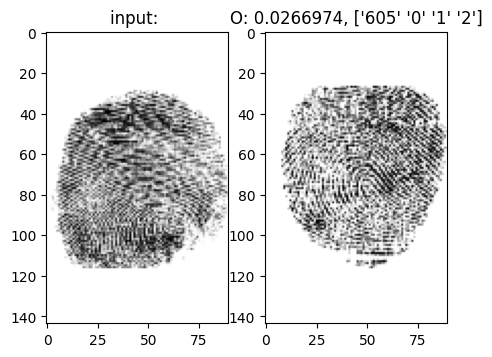

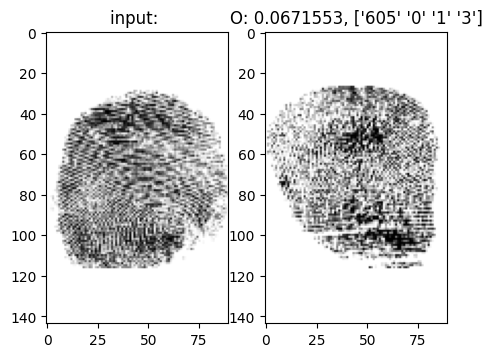

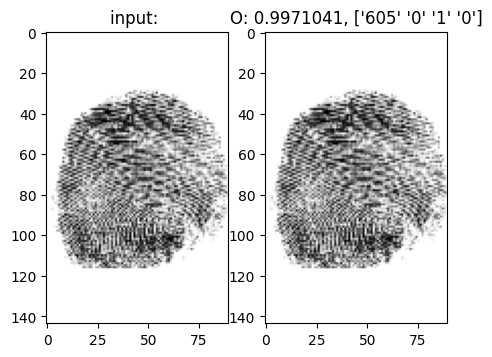

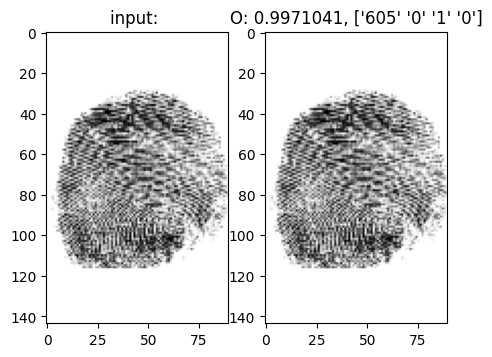

In [60]:
X = np.load('new1.npz')
Y=np.load('tar1.npy')
random_idx1 = random.randint(0, len(X))
# random_idx=2995
random_img1 = X[random_idx1]
random_label1= Y[random_idx1]
seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=255
    )
], random_order=True)

random_img1 = random_img1.reshape((1, 144, 90, 1)).astype(np.float32) #/ 255.
ans1=0.0
ansxx=None
ansyy=None
l=0
r=len(X)
while l<r:
    rxx = X[l].reshape((1, 144, 90, 1)).astype(np.float32) #/ 255.
    ryy=Y[l]
    pred_rxx=mp.predict([random_img1,rxx])
    print(pred_rxx)
    if pred_rxx>ans1:
        ans1=pred_rxx
        ansxx=X[l]
        ansyy=Y[l]
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 3, 1)
    # plt.title('input: %s' %  random_label1)
    plt.title('input: ')
    plt.imshow(random_img1.squeeze(), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title('O: %.07f, %s' % (pred_rxx, ryy))
    plt.imshow(rxx.squeeze(), cmap='gray')
    l+=1
plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
# plt.title('input: %s' %  random_label1)
plt.title('input: ')
plt.imshow(random_img1.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('O: %.07f, %s' % (ans1, ansyy))
plt.imshow(ansxx.squeeze(), cmap='gray')
# print(ansxx)
